# Image Classification With Neural Networks

## 1.1 BUSINESS UNDERSTANDING


The rapid advancement of Artificial Intelligence (AI) has brought significant benefits across various industries, including healthcare. Pneumonia, a critical lung infection, poses a serious threat, particularly to vulnerable demographics like the elderly and children. Traditionally, diagnosing pneumonia requires time-consuming physical examinations and lab tests, often necessitating multiple doctor visits.

To address this issue, we aim to develop a deep learning model capable of accurately detecting pneumonia from chest x-ray images. Such a tool holds immense value for healthcare professionals and patients, enabling quicker and more precise diagnoses. Radiologists and other specialists can leverage this technology to enhance their diagnostic accuracy, ultimately leading to better patient care and treatment outcomes.

Key stakeholders interested in leveraging deep learning for medical imaging include healthcare professionals, patients, hospitals, medical device manufacturers, and insurance companies. For instance, hospitals can optimize resource allocation and improve treatment efficacy, while medical device manufacturers can enhance product development for more accurate diagnoses. Additionally, researchers and government agencies stand to benefit from these advancements, using the models to deepen disease understanding and ensure regulatory compliance.

In summary, leveraging deep learning for medical imaging presents a transformative opportunity to enhance diagnostic accuracy, improve patient outcomes, and streamline healthcare processes across various stakeholders.

## 1.2. Technical Objectives

- Develop a deep learning model to accurately identify pneumonia from chest x-ray images.
- Fine-tune model architecture and parameters for optimal accuracy on validation data.
- Apply data augmentation techniques to enhance model generalization by expanding the training dataset.
- Experiment with various optimization methods and batch sizes to improve training efficiency and stability.
- Assess model performance using precision, recall, and F1 score metrics.

## 1.3. Business Objectives


- Provide pediatricians with a fast and precise tool for pneumonia diagnosis in children, potentially reducing unnecessary hospital visits and improving outcomes.
- Enhance access to pneumonia diagnosis in low-resource settings without immediate access to trained medical professionals.
- Potentially lower healthcare expenses by enabling early diagnosis and treatment of pneumonia in pediatric cases.
- Contribute to building a comprehensive dataset for pneumonia diagnosis, facilitating further research and model advancement.
- Develop a user-friendly model for seamless integration into existing hospital or clinic workflows, ensuring efficient and streamlined diagnosis processes.

## 1.4. Data Understanding

The dataset comprises 5,863 JPEG images categorized into two classes: "Pneumonia" and "Normal." It is organized into three main folders: "train," "test," and "val," each containing subfolders corresponding to the image categories.

The chest X-ray images, captured in the anterior-posterior view, were obtained from pediatric patients aged one to five years old at Guangzhou Women and Children’s Medical Center, Guangzhou. These images were part of routine clinical care procedures.

Before inclusion in the dataset, all chest radiographs underwent a quality control process to remove any low-quality or unreadable scans. Subsequently, the diagnoses assigned to the images were graded by two expert physicians. To mitigate potential grading errors, a third expert also evaluated the images in the evaluation set.

Overall, this dataset provides a curated collection of chest X-ray images, ensuring quality and accuracy through rigorous quality control measures and expert evaluation, making it suitable for training AI systems for pneumonia diagnosis.

In [10]:
# Importing the necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import Sequential
from keras import layers, models, regularizers, optimizers
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from sklearn.metrics import classification_report

In [2]:
# Set the paths to train, test, and validation folders
train_folder = 'chest_xray/train'
test_folder = 'chest_xray/test'
val_folder = 'chest_xray/val'

# Downsampling the images to 128X128 pixels
downsampled_size = (128, 128)

# Define batch sizes
train_batch_size = 5216
test_batch_size = 624
val_batch_size = 16

# Rescale pixel values between 0 and 1
datagen = ImageDataGenerator(rescale=1./255)  

def load_data(data_dir, batch_size, datagen, downsampled_size, is_train_data):
    try:
        generator = datagen.flow_from_directory(
            data_dir,
            target_size=downsampled_size,
            batch_size=batch_size,
            class_mode='binary',
            shuffle=is_train_data
        )
    except Exception as e:
        raise Exception(f"Error loading data from {data_dir}: {e}") from e
    return generator

# Load the train data
train_generator = load_data(train_folder, train_batch_size, datagen, downsampled_size, True)

# Load the test data
test_generator = load_data(test_folder, test_batch_size, datagen, downsampled_size, False)

# Load the validation data
val_generator = load_data(val_folder, val_batch_size, datagen, downsampled_size, False)


Found 5216 images belonging to 2 classes.
Found 624 images belonging to 2 classes.
Found 16 images belonging to 2 classes.


## Data Visualization & Preprocessing
### EDA

In [3]:
# Retrieve the dictionary of class indices from the train_generator
dict_class = train_generator.class_indices
print(f'Dictionary: {dict_class}')

# Get the list of class labels
class_names = list(dict_class.keys())
print(f'Class labels: {class_names}')


Dictionary: {'NORMAL': 0, 'PNEUMONIA': 1}
Class labels: ['NORMAL', 'PNEUMONIA']


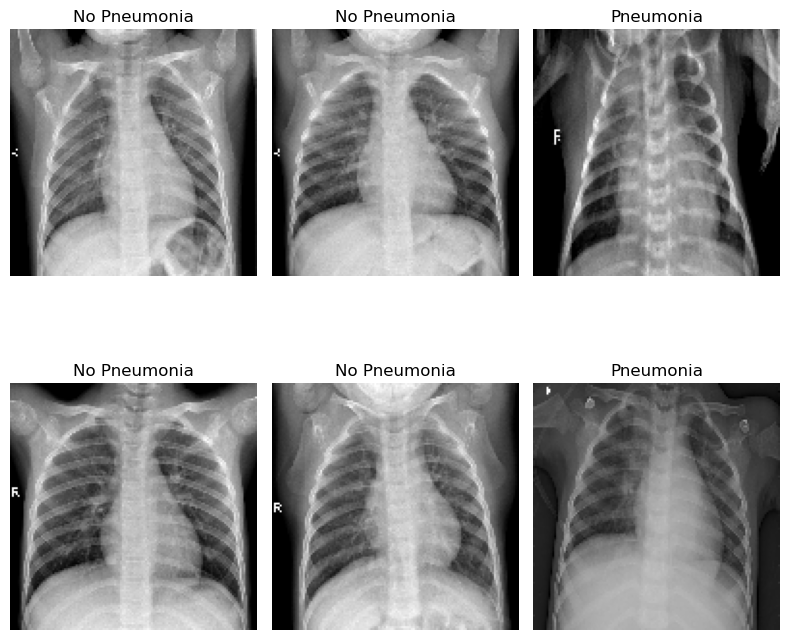

In [4]:
# Get a batch of images and labels from the train_generator
images, labels = next(train_generator)

# Define the number of images to display
num_images = 6

# Create a 2x3 subplot figure with adjusted aspect ratio
fig, axes = plt.subplots(2, 3, figsize=(8, 8), subplot_kw={'aspect': 'auto'})

# Loop over the first few images
for i in range(min(num_images, len(images))):
    # Display the image
    axes[i//3, i%3].imshow(images[i], cmap='gray')  # Assuming grayscale images
    # Set the title to the corresponding label
    if labels[i] == 0:
        axes[i//3, i%3].set_title('No Pneumonia')
    else:
        axes[i//3, i%3].set_title('Pneumonia')
    # Remove the axis
    axes[i//3, i%3].axis('off')

# Adjust the layout and display the figure
plt.tight_layout()
plt.show()


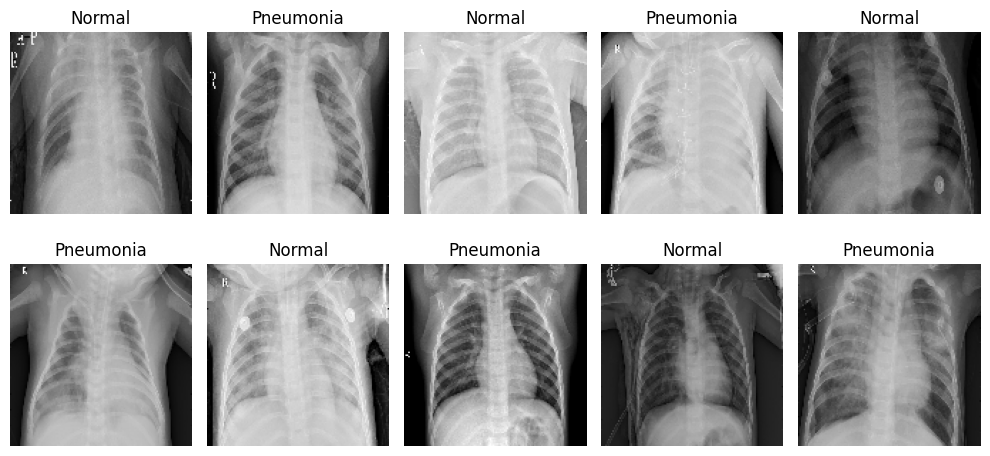

In [ ]:
# Define the number of images to display
num_images = 10

# Create a 2x5 subplot figure with adjusted aspect ratio
fig, axes = plt.subplots(2, 5, figsize=(10, 5))
axes = axes.ravel()

# Get a batch of 'Normal' and 'Pneumonia' images
normal_images, _ = train_generator.next()
pneumonia_images, _ = train_generator.next()

# Loop over the first few images
for i in range(min(num_images, len(normal_images), len(pneumonia_images))):
    # Display the image
    if i % 2 == 0:
        axes[i].imshow(normal_images[i], cmap='gray')
        axes[i].set_title('Normal')
    else:
        axes[i].imshow(pneumonia_images[i], cmap='gray')
        axes[i].set_title('Pneumonia')
    # Remove the axis
    axes[i].axis('off')

# Adjust the layout and display the figure
plt.tight_layout()
plt.show()

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

def visualize_class_distributions(train_generator, test_generator, val_generator, class_names):
    """
    Visualizes the class distributions for the training, test, and validation data.
    
    Args:
        train_generator (ImageDataGenerator): The training data generator.
        test_generator (ImageDataGenerator): The test data generator.
        val_generator (ImageDataGenerator): The validation data generator.
        class_names (list): The list of class names.
    """
    # Count the occurrences of each class in the training data
    train_class_counts = np.bincount(train_generator.classes)
    
    # Count the occurrences of each class in the test data
    test_class_counts = np.bincount(test_generator.classes)
    
    # Count the occurrences of each class in the validation data
    val_class_counts = np.bincount(val_generator.classes)
    
    # Create a figure with three subplots
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 5))
    
    # Plot the training data class distribution
    ax1.bar(class_names, train_class_counts)
    ax1.set_title('Training Data Class Distribution')
    ax1.set_xlabel('Class')
    ax1.set_ylabel('Count')
    
    # Plot the test data class distribution
    ax2.bar(class_names, test_class_counts)
    ax2.set_title('Test Data Class Distribution')
    ax2.set_xlabel('Class')
    ax2.set_ylabel('Count')
    
    # Plot the validation data class distribution
    ax3.bar(class_names, val_class_counts)
    ax3.set_title('Validation Data Class Distribution')
    ax3.set_xlabel('Class')
    ax3.set_ylabel('Count')
    
    plt.tight_layout()
    plt.show()

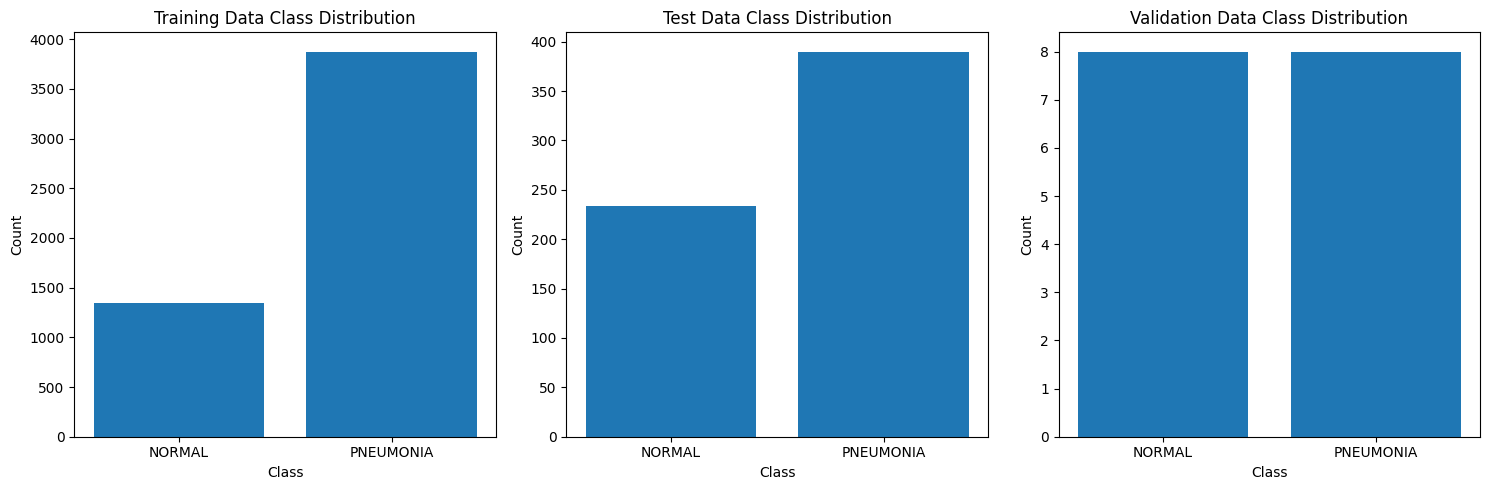

In [ ]:
# Call the function with your data generators and class names
visualize_class_distributions(train_generator, test_generator, val_generator, class_names)

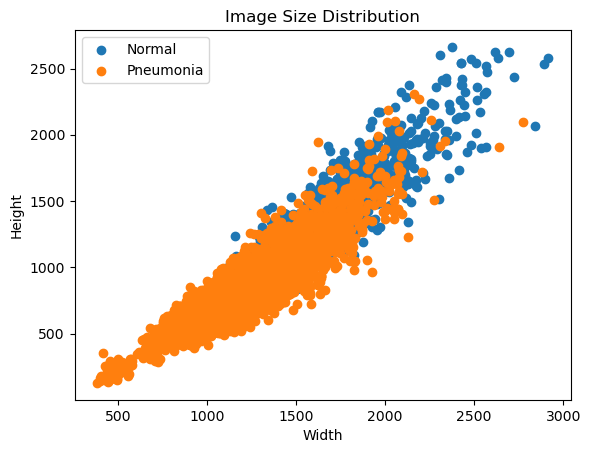

In [5]:
from PIL import Image
normal_image_sizes = []
pneumonia_image_sizes = []
for image_path in train_generator.filepaths:
    img = Image.open(image_path)
    width, height = img.size
    if "NORMAL" in image_path:
        normal_image_sizes.append((width, height))
    else:
        pneumonia_image_sizes.append((width, height))
normal_image_sizes = np.array(normal_image_sizes)
pneumonia_image_sizes = np.array(pneumonia_image_sizes)
plt.scatter(normal_image_sizes[:, 0], normal_image_sizes[:, 1], label='Normal')
plt.scatter(pneumonia_image_sizes[:, 0], pneumonia_image_sizes[:, 1], label='Pneumonia')
plt.xlabel('Width')
plt.ylabel('Height')
plt.title('Image Size Distribution')
plt.legend()
plt.show()

In [6]:
# obtain images and labels from the test generator
train_images, train_labels = next(train_generator)
test_images, test_labels = next(test_generator)
val_images, val_labels = next(val_generator)

In [7]:
# Explore the shape of the images and labels
m_train = train_images.shape[0]
num_px = train_images.shape[1]
m_test = test_images.shape[0]
m_val = val_images.shape[0]

train_labels =np.array(train_labels)
test_labels =np.array(test_labels)
val_labels = np.array(val_labels)


print ("Number of training samples: " + str(m_train))
print ("Number of testing samples: " + str(m_test))
print ("Number of validation samples: " + str(m_val))
print ("train_images shape: " + str(train_images.shape))
print ("train_labels shape: " + str(train_labels.shape))
print ("test_images shape: " + str(test_images.shape))
print ("test_labels shape: " + str(test_labels.shape))
print ("val_images shape: " + str(val_images.shape))
print ("val_labels shape: " + str(val_labels.shape))

Number of training samples: 5216
Number of testing samples: 624
Number of validation samples: 16
train_images shape: (5216, 128, 128, 3)
train_labels shape: (5216,)
test_images shape: (624, 128, 128, 3)
test_labels shape: (624,)
val_images shape: (16, 128, 128, 3)
val_labels shape: (16,)


In [8]:
# Reshaping the images
# number of images per data, 128X128X3
train_img = train_images.reshape(train_images.shape[0], -1)
test_img = test_images.reshape(test_images.shape[0], -1)
val_img = val_images.reshape(val_images.shape[0], -1)

print(train_img.shape)
print(test_img.shape)
print(val_img.shape)

(5216, 49152)
(624, 49152)
(16, 49152)


# Modeling
## Baseline model : A Densely Connected Neural Network


In [11]:
# Build a baseline fully connected network

#initialize a sequential model
model_1 = models.Sequential()

#2 layers with relu activation
model_1.add(layers.Dense(64, activation='relu', input_shape=(49152,))) 
model_1.add(layers.Dense(32, activation='relu'))

#one layer with sigmoid activation
model_1.add(layers.Dense(1, activation='sigmoid'))

c:\Users\FLO\anaconda3\envs\learn-env\lib\site-packages\keras\src\layers\core\dense.py:86: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [13]:
#compile the model
model_1.compile(optimizer='sgd',
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [14]:
model_1.summary()


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 64)             │     3,145,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,147,905 (12.01 MB)

 Trainable params: 3,147,905 (12.01 MB)

 Non-trainable params: 0 (0.00 B)

In [15]:
#train the model
results_1 = model_1.fit(train_img,
                    train_labels,
                    epochs=10,
                    batch_size=100,

                    validation_data=(val_img, val_labels))

Epoch 1/10
53/53 ━━━━━━━━━━━━━━━━━━━━ 26s 96ms/step - accuracy: 0.7256 - loss: 0.7200 - val_accuracy: 0.5000 - val_loss: 1.2286
Epoch 2/10
53/53 ━━━━━━━━━━━━━━━━━━━━ 3s 50ms/step - accuracy: 0.7923 - loss: 0.5059 - val_accuracy: 0.6250 - val_loss: 0.7013
Epoch 3/10
53/53 ━━━━━━━━━━━━━━━━━━━━ 3s 50ms/step - accuracy: 0.8230 - loss: 0.4129 - val_accuracy: 0.8125 - val_loss: 0.4699
Epoch 4/10
53/53 ━━━━━━━━━━━━━━━━━━━━ 3s 50ms/step - accuracy: 0.8652 - loss: 0.3389 - val_accuracy: 0.8125 - val_loss: 0.5157
Epoch 5/10
53/53 ━━━━━━━━━━━━━━━━━━━━ 3s 48ms/step - accuracy: 0.8702 - loss: 0.2930 - val_accuracy: 0.6250 - val_loss: 0.8293
Epoch 6/10
53/53 ━━━━━━━━━━━━━━━━━━━━ 3s 52ms/step - accuracy: 0.8941 - loss: 0.2504 - val_accuracy: 0.5625 - val_loss: 1.3754
Epoch 7/10
53/53 ━━━━━━━━━━━━━━━━━━━━ 3s 48ms/step - accuracy: 0.8917 - loss: 0.2727 - val_accuracy: 0.6250 - val_loss: 1.1726
Epoch 8/10
53/53 ━━━━━━━━━━━━━━━━━━━━ 3s 50ms/step - accuracy: 0.9179 - loss: 0.2252 - val_accuracy: 0.8750 - 

In [16]:
"""Function to plot the loss and Accuracy curves"""
def visualize_training_results_dense(results):
    history = results.history
    plt.figure()
    plt.plot(history['val_loss'])
    plt.plot(history['loss'])
    plt.legend(['val_loss', 'loss'])
    plt.title('Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.show()
    
    plt.figure()
    plt.plot(history['val_accuracy'])
    plt.plot(history['accuracy'])
    plt.legend(['val_acc', 'acc'])
    plt.title('Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.show()

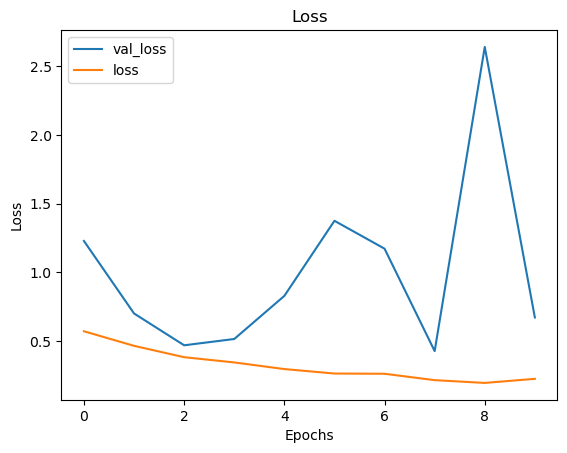

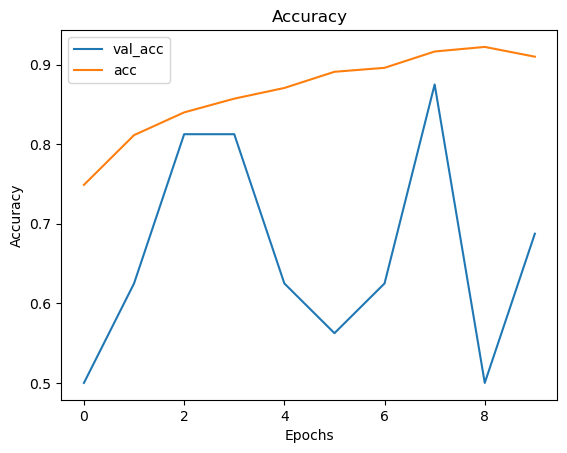

In [17]:
visualize_training_results_dense(results_1)


In [18]:
"""Function that return loss and accuracy of a model"""
def model_metrics(model, images, labels):
    return model.evaluate(images, labels)

In [19]:
results_train = model_metrics(model_1, train_img, train_labels)
results_train

163/163 ━━━━━━━━━━━━━━━━━━━━ 30s 14ms/step - accuracy: 0.9202 - loss: 0.1929


[0.1871260404586792, 0.9208205342292786]

In [20]:
results_val = model_metrics(model_1, val_img, val_labels)
results_val

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 269ms/step - accuracy: 0.6875 - loss: 0.6723


[0.6723254919052124, 0.6875]

# model 2: CNN


The second model comprises a sequential architecture consisting of two convolutional layers, each followed by max pooling layers. These convolutional layers are responsible for extracting features from the input images, while the subsequent max pooling layers reduce the spatial dimensions of the feature maps. Finally, the model concludes with a dense layer, which performs the classification task.

In [21]:
# Initialize a sequential model 
model_2 = models.Sequential()

# Add 2 convolutional layers with pooling
model_2.add(layers.Conv2D(64, (3, 3), activation='relu', input_shape=(128, 128, 3)))
model_2.add(layers.MaxPooling2D((2, 2)))

model_2.add(layers.Conv2D(32, (3, 3), activation='relu'))
model_2.add(layers.MaxPooling2D((2, 2)))

# Flatten the output to feed into the next layer
model_2.add(layers.Flatten())

# Add a dense layer for classification
model_2.add(layers.Dense(1, activation='sigmoid'))


c:\Users\FLO\anaconda3\envs\learn-env\lib\site-packages\keras\src\layers\convolutional\base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


In [22]:
# Compile the model
model_2.compile(loss='binary_crossentropy',
                optimizer='sgd',
                metrics=['accuracy'])

# Print a summary of the model architecture
model_2.summary()


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 126, 126, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 63, 63, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 61, 61, 32)     │        18,464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 30, 30, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 28800)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │        28,801 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 49,057 (191.63 KB)

 Trainable params: 49,057 (191.63 KB)

 Non-trainable params: 0 (0.00 B)

In [29]:
"""Function to plot the loss function"""
def visualize_training_results(results):
    history = results.history
    plt.figure()
    plt.plot(history['val_loss'])
    plt.plot(history['loss'])
    plt.legend(['val_loss', 'loss'])
    plt.title('Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.show()
    
    plt.figure()
    plt.plot(history['val_accuracy'])
    plt.plot(history['accuracy'])
    plt.legend(['val_acc', 'acc'])
    plt.title('Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.show()

In [24]:
results_2 = model_2.fit(train_images,
                    train_labels,
                    epochs=10,
                    batch_size=100,
                    validation_data=(val_images, val_labels))

Epoch 1/10
53/53 ━━━━━━━━━━━━━━━━━━━━ 211s 4s/step - accuracy: 0.7385 - loss: 0.5710 - val_accuracy: 0.5000 - val_loss: 1.0344
Epoch 2/10
53/53 ━━━━━━━━━━━━━━━━━━━━ 83s 2s/step - accuracy: 0.7794 - loss: 0.5005 - val_accuracy: 0.5000 - val_loss: 1.2849
Epoch 3/10
53/53 ━━━━━━━━━━━━━━━━━━━━ 86s 2s/step - accuracy: 0.8068 - loss: 0.4659 - val_accuracy: 0.7500 - val_loss: 0.5616
Epoch 4/10
53/53 ━━━━━━━━━━━━━━━━━━━━ 86s 2s/step - accuracy: 0.8880 - loss: 0.3139 - val_accuracy: 0.6250 - val_loss: 1.0264
Epoch 5/10
53/53 ━━━━━━━━━━━━━━━━━━━━ 85s 2s/step - accuracy: 0.8857 - loss: 0.2787 - val_accuracy: 0.6250 - val_loss: 0.8714
Epoch 6/10
53/53 ━━━━━━━━━━━━━━━━━━━━ 140s 2s/step - accuracy: 0.9062 - loss: 0.2285 - val_accuracy: 0.5625 - val_loss: 1.8803
Epoch 7/10
53/53 ━━━━━━━━━━━━━━━━━━━━ 84s 2s/step - accuracy: 0.9191 - loss: 0.2152 - val_accuracy: 0.8125 - val_loss: 0.4490
Epoch 8/10
53/53 ━━━━━━━━━━━━━━━━━━━━ 86s 2s/step - accuracy: 0.8900 - loss: 0.2660 - val_accuracy: 0.8125 - val_los

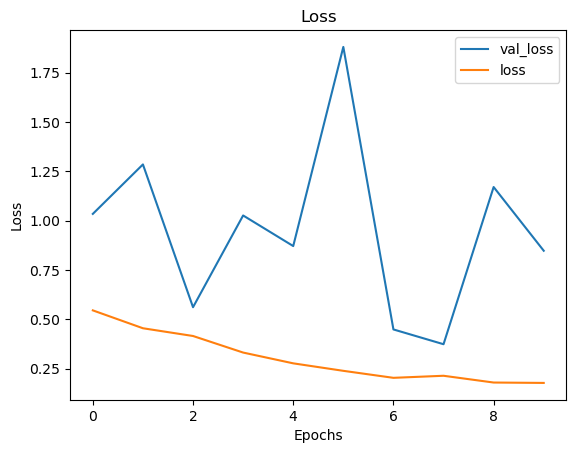

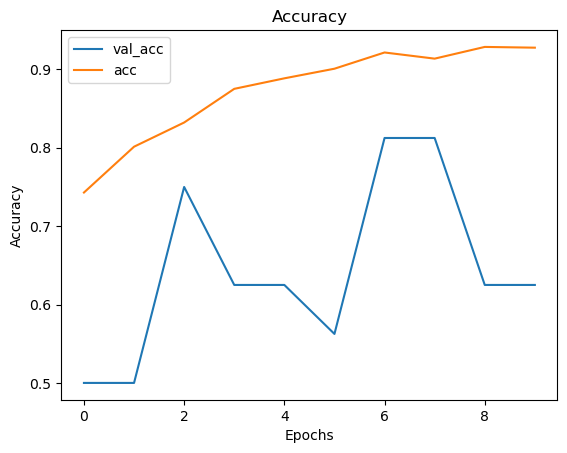

In [30]:
#visualizing loss and accuracy for the cnn model
visualize_training_results(results_2)


In [31]:
#model evaluation
results_train = model_metrics(model_2, train_images, train_labels)
results_train


163/163 ━━━━━━━━━━━━━━━━━━━━ 58s 144ms/step - accuracy: 0.9116 - loss: 0.2013


[0.19864052534103394, 0.9143021702766418]

In [32]:
#model evaluation
results_val = model_metrics(model_2, val_images, val_labels)
results_val

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 224ms/step - accuracy: 0.6250 - loss: 0.8477


[0.8476594686508179, 0.625]

# Tuning CNN
## Model 3 - CNN with Regularization and Dropout



In [33]:
# Instantiate a baseline model
model_3_1 = models.Sequential()

# Add convolutional layers with max pooling and dropout
model_3_1.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(128, 128, 3)))
model_3_1.add(layers.MaxPooling2D((2, 2)))
model_3_1.add(layers.Dropout(0.25))

model_3_1.add(layers.Conv2D(64, (3, 3), activation='relu'))
model_3_1.add(layers.MaxPooling2D((2, 2)))
model_3_1.add(layers.Dropout(0.25))

model_3_1.add(layers.Conv2D(64, (3, 3), activation='relu'))
model_3_1.add(layers.MaxPooling2D((2, 2)))
model_3_1.add(layers.Dropout(0.25))

# Flatten layer and dense layers for classification
model_3_1.add(layers.Flatten())
model_3_1.add(layers.Dense(64, activation='relu'))
model_3_1.add(layers.Dense(1, activation='sigmoid'))


In [34]:
model_3_1.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

In [35]:
results_3_1 = model_3_1.fit(train_images,
                    train_labels,
                    epochs=10,
                    batch_size=32,
                    validation_data=(val_images, val_labels))

Epoch 1/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 125s 594ms/step - accuracy: 0.7628 - loss: 0.5262 - val_accuracy: 0.7500 - val_loss: 0.4880
Epoch 2/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 91s 554ms/step - accuracy: 0.9525 - loss: 0.1374 - val_accuracy: 0.7500 - val_loss: 0.3384
Epoch 3/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 91s 559ms/step - accuracy: 0.9610 - loss: 0.1047 - val_accuracy: 0.8750 - val_loss: 0.2641
Epoch 4/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 130s 485ms/step - accuracy: 0.9685 - loss: 0.0856 - val_accuracy: 0.5625 - val_loss: 0.8639
Epoch 5/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 86s 528ms/step - accuracy: 0.9634 - loss: 0.0910 - val_accuracy: 1.0000 - val_loss: 0.0955
Epoch 6/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 95s 585ms/step - accuracy: 0.9660 - loss: 0.0774 - val_accuracy: 0.6875 - val_loss: 0.6737
Epoch 7/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 84s 515ms/step - accuracy: 0.9744 - loss: 0.0674 - val_accuracy: 0.8750 - val_loss: 0.2351
Epoch 8/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 92s 567ms/step - accuracy: 0.9823 - loss:

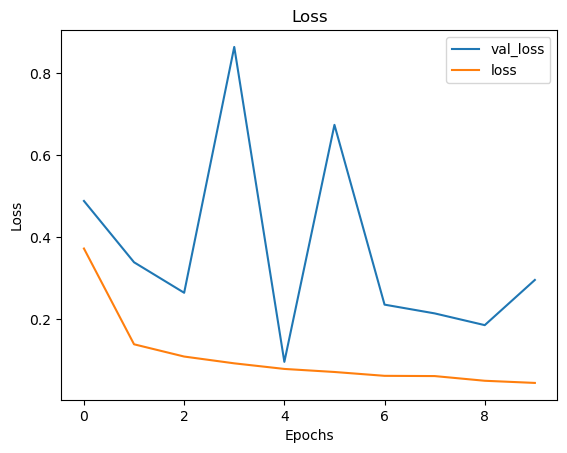

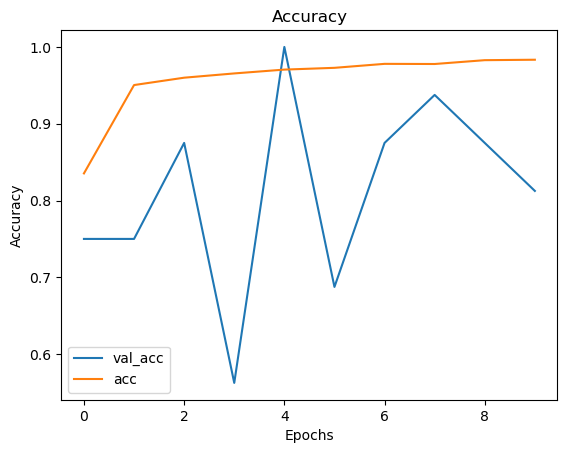

In [36]:
visualize_training_results_dense(results_3_1)


In [38]:
#model  perfomnce evaluation
results_train = model_metrics(model_3_1, train_images, train_labels)
results_train

163/163 ━━━━━━━━━━━━━━━━━━━━ 23s 138ms/step - accuracy: 0.9857 - loss: 0.0415


[0.04120706766843796, 0.985237717628479]

In [39]:
#model evaluation
results_val = model_metrics(model_3_1, val_images, val_labels)
results_val

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 184ms/step - accuracy: 0.8125 - loss: 0.2954


[0.29536083340644836, 0.8125]

# Model 4 - CNN with Architecture modifications
## Adding More Layers


In [45]:
model_4 = models.Sequential()
model_4.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(128, 128, 3)))
model_4.add(layers.MaxPooling2D((2, 2)))

model_4.add(layers.Conv2D(64, (3, 3), activation='relu'))
model_4.add(layers.MaxPooling2D((2, 2)))

model_4.add(layers.Conv2D(128, (3, 3), activation='relu'))
model_4.add(layers.MaxPooling2D((2, 2)))

model_4.add(layers.Conv2D(128, (3, 3), activation='relu'))
model_4.add(layers.MaxPooling2D((2, 2)))


model_4.add(layers.Conv2D(256, (3, 3), activation='relu'))
model_4.add(layers.MaxPooling2D((2, 2)))

model_4.add(layers.Flatten())
model_4.add(layers.Dense(512, activation='relu'))
model_4.add(layers.Dense(256, activation='relu'))
model_4.add(layers.Dense(1, activation='sigmoid'))

c:\Users\FLO\anaconda3\envs\learn-env\lib\site-packages\keras\src\layers\convolutional\base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


In [46]:
model_4.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

In [48]:
results_4 = model_4.fit(train_images,
                    train_labels,
                    epochs=10,
                    batch_size=32,
                    validation_data=(val_images, val_labels))

Epoch 1/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 129s 670ms/step - accuracy: 0.7475 - loss: 0.5976 - val_accuracy: 0.6250 - val_loss: 0.7538
Epoch 2/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 103s 633ms/step - accuracy: 0.8825 - loss: 0.2796 - val_accuracy: 0.7500 - val_loss: 0.8646
Epoch 3/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 143s 636ms/step - accuracy: 0.9509 - loss: 0.1393 - val_accuracy: 0.9375 - val_loss: 0.1450
Epoch 4/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 86s 529ms/step - accuracy: 0.9601 - loss: 0.0951 - val_accuracy: 0.8125 - val_loss: 0.3115
Epoch 5/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 89s 548ms/step - accuracy: 0.9766 - loss: 0.0698 - val_accuracy: 0.8750 - val_loss: 0.1563
Epoch 6/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 139s 526ms/step - accuracy: 0.9808 - loss: 0.0541 - val_accuracy: 0.6250 - val_loss: 1.5640
Epoch 7/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 90s 549ms/step - accuracy: 0.9802 - loss: 0.0593 - val_accuracy: 0.8125 - val_loss: 0.4677
Epoch 8/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 135s 508ms/step - accuracy: 0.9848 - lo

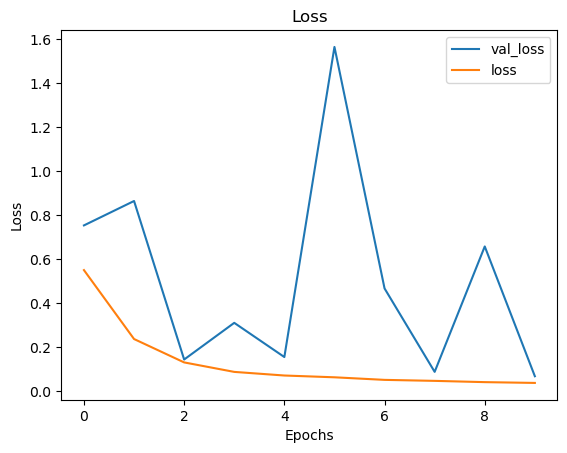

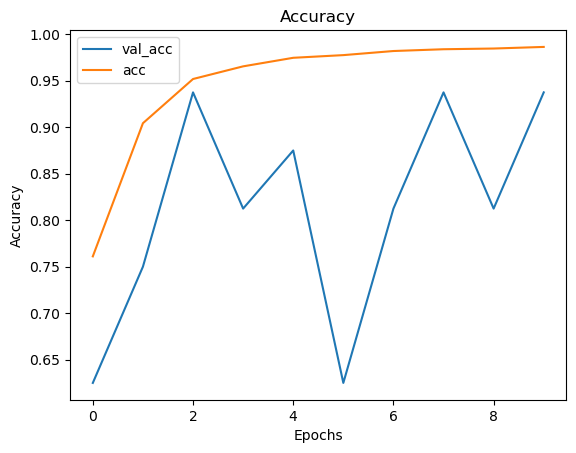

In [50]:
visualize_training_results_dense(results_4)


In [51]:
#model  perfomance evaluation
results_train = model_metrics(model_4, train_images, train_labels)
results_train

163/163 ━━━━━━━━━━━━━━━━━━━━ 22s 132ms/step - accuracy: 0.9840 - loss: 0.0376


[0.031482040882110596, 0.9863880276679993]

In [52]:
#model  perfomnce evaluation
results_val = model_metrics(model_4, val_images, val_labels)
results_val

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step - accuracy: 0.9375 - loss: 0.0691


[0.06910967081785202, 0.9375]

# Model Evaluation


In [58]:
# Evaluate the model on the test dataset
test_loss, test_accuracy = model_metrics(model_2, test_images, test_labels)

# Print the test loss and accuracy
print("Test Loss:", test_loss)
print("Test Accuracy:", test_accuracy)

20/20 ━━━━━━━━━━━━━━━━━━━━ 3s 115ms/step - accuracy: 0.4331 - loss: 1.6034
Test Loss: 0.8911914229393005
Test Accuracy: 0.6955128312110901


In [49]:
# Evaluate the model on the test dataset
test_loss, test_accuracy = model_metrics(model_4, test_images, test_labels)

# Print the test loss and accuracy
print("Test Loss:", test_loss)
print("Test Accuracy:", test_accuracy)

20/20 ━━━━━━━━━━━━━━━━━━━━ 2s 123ms/step - accuracy: 0.6969 - loss: 1.8141
Test Loss: 1.1312824487686157
Test Accuracy: 0.8108974099159241


To interpret the results of the two models for image classification on pneumonia X-ray scan images, we need to analyze their test loss and test accuracy.

1. Model 2 (Simple CNN):

Test Loss: 0.8912
Test Accuracy: 0.6955
This model achieved a test loss of 0.8912, indicating that, on average, it's making predictions with a moderate level of error. The test accuracy of 0.6955 suggests that it correctly classified approximately 69.55% of the pneumonia X-ray scan images in the test dataset. While the accuracy is decent, there is room for improvement in reducing the test loss, which would indicate more precise predictions.

2. Model 4 (CNN with Architecture Modifications):

Test Loss: 1.1313
Test Accuracy: 0.8109
The CNN model with architecture modifications achieved a higher test accuracy of 0.8109 compared to Model 2, indicating that it correctly classified approximately 81.09% of the pneumonia X-ray scan images in the test dataset. However, the test loss is slightly higher at 1.1313, indicating a slightly higher level of error compared to Model 2.

In summary:

Model 4 outperforms Model 2 in terms of test accuracy, indicating better overall performance in classifying pneumonia X-ray scan images.
Model 2 has a lower test loss compared to Model 4, suggesting slightly more precise predictions on average. However, Model 4's higher accuracy indicates its better ability to classify the images correctly despite the slightly higher loss.

# Predictions


20/20 ━━━━━━━━━━━━━━━━━━━━ 3s 139ms/step


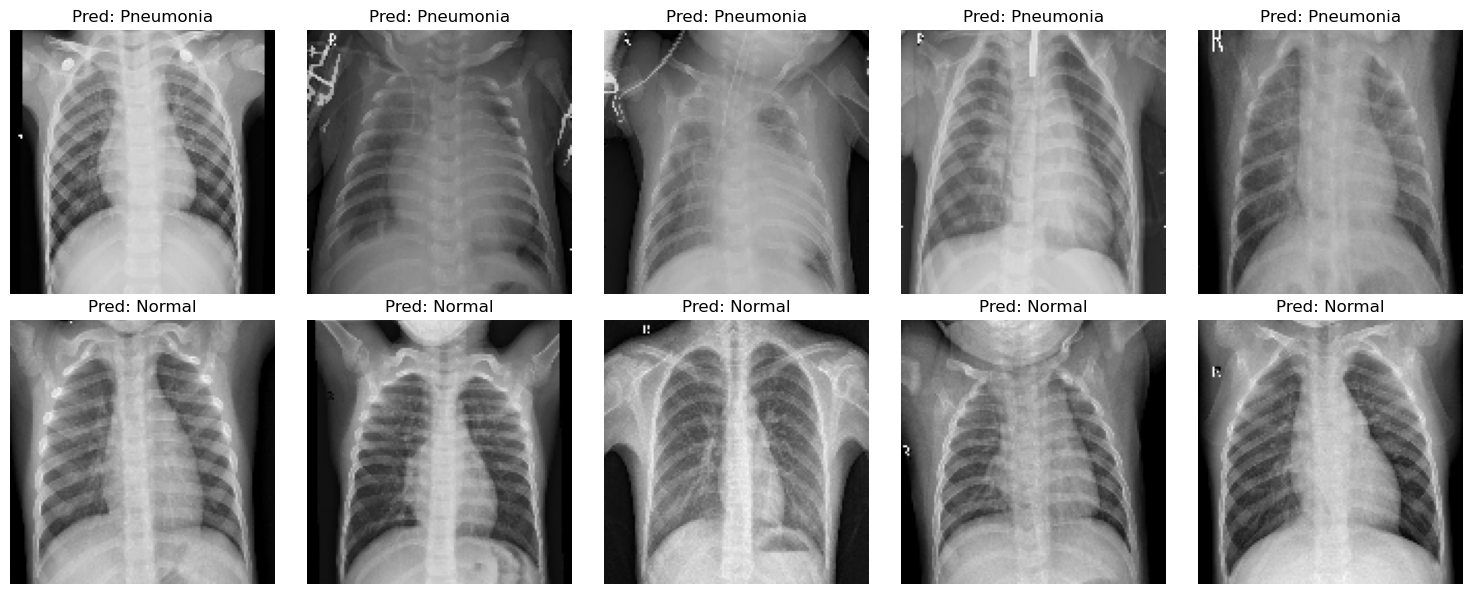

In [61]:
import numpy as np
import matplotlib.pyplot as plt

# Predictions of model 4 which is the best evaluated model
predictions = model_4.predict(test_images)

# Convert predictions to class labels (0 or 1)
predicted_labels = np.round(predictions)

# Create an array of indices
indices = np.arange(len(predicted_labels))

# Shuffle the indices
np.random.shuffle(indices)

# Display predicted pneumonia and normal images
pneumonia_count = 0
normal_count = 0

fig, axs = plt.subplots(2, 5, figsize=(15, 6))

for i in indices:
    if pneumonia_count >= 5 and normal_count >= 5:
        break

    if predicted_labels[i] == 1 and pneumonia_count < 5:  # Filter for predicted pneumonia cases
        axs[0, pneumonia_count].imshow(test_images[i])
        axs[0, pneumonia_count].axis('off')
        axs[0, pneumonia_count].set_title(f"Pred: Pneumonia")
        pneumonia_count += 1

    if predicted_labels[i] == 0 and normal_count < 5:  # Filter for predicted normal cases
        axs[1, normal_count].imshow(test_images[i])
        axs[1, normal_count].axis('off')
        axs[1, normal_count].set_title(f"Pred: Normal")
        normal_count += 1

plt.tight_layout()
plt.show()

# Conclusion
